In [25]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from numpy import set_printoptions
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import ensemble


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

Initial preprocessing of the data, we had to remove columns with over 1000 missing values for the analysis to work.

In [4]:
ames_data = pd.read_csv("AmesHousing.csv")
is_na_mask = ames_data.isna().sum()
missing_columns = is_na_mask[is_na_mask > 1000].index #these are the columns with over 1000 missing values, I want them gone
ames_data.drop(columns = missing_columns, inplace = True)
ames_data.dropna(inplace=True)

We will now separate the data into numerical data, categorical data, and a combination of the two.

In [5]:
#the numerical data
numerical_columns = [val for val in ames_data.describe().columns if val not in ["SalePrice",'Overall Qual']] 
#removing Overall Quality because I want to see if the other metrics can still accurately predict price
numerical_ames_data = ames_data[numerical_columns]
numerical_ames_data = numerical_ames_data.dropna()

In [6]:
#the categorical and combined data
#learned how to encode categorical columns from: https://medium.com/byteridge/encoding-categorical-values-in-python-scikit-learn-51b04b4bb5fa
categorical_columns = [val for val in ames_data.columns if val not in ames_data.describe().columns]
categorical_df = ames_data[categorical_columns]
le = LabelEncoder()
encoded_categorical_df = categorical_df.astype(str).apply(le.fit_transform) #essentially this is transforming the categorical data into numerical 
combined_df = encoded_categorical_df.join(numerical_ames_data)#the encoded categorical data + the numerical data

This Best Features Class makes it very easy to extract the most significant features of a given dataset (numerical data, categorical data, combined data). We used the Random Forest and univariate feature selection techniques.

In [7]:
class Best_Features:
    '''Extracts the most important features in predicting house sale price using random forest and univariate selection techniques'''
    def __init__(self, k, input_df):
        '''K is the number of features you want displayed, input_df is the particular dataframe you're using'''
        self.k = k
        self.input_df = input_df
    
    def features_and_labels_generator(self):
        '''Splits the input dataframe into feature and label vectors'''
        feature_columns = self.input_df.columns
        feature_vectors = np.array(self.input_df[feature_columns])
        class_labels = np.array(ames_data["SalePrice"])
        return (feature_vectors, class_labels)
        
    def univariate_feature_selector(self):
        '''returns k best features for dataset based on univariate selection'''
        x,y = self.features_and_labels_generator()
        fs = SelectKBest(score_func=f_regression, k=self.k)
        # apply feature selection
        fit = fs.fit_transform(x, y)
        univariate_feature_columns = self.input_df.columns[fs.get_support(indices=True)]
        return univariate_feature_columns
    
    def random_forest_feature_selector(self):
        '''returns k best features for dataset based on random forest model'''
        x,y = self.features_and_labels_generator()
        total_x_train, total_x_test, total_y_train, total_y_test = train_test_split(x, y, test_size=0.25)
        feat_select_clf = RandomForestRegressor(n_estimators = 100, random_state=0)
        feat_select_clf.fit(total_x_train, total_y_train)
        important_features = list(zip(self.input_df.columns,feat_select_clf.feature_importances_))
        important_features.sort(key = lambda pair: pair[1], reverse = True)
        random_f_best_features = [pair[0] for pair in important_features[0:self.k]]
        return random_f_best_features
    
    def total_best_features(self):
        '''returns dataframe of intersection of univariate and random_forest features'''
        univariate_best_features = self.univariate_feature_selector()
        random_f_best_features = self.random_forest_feature_selector()
        total_best_features = list(set(univariate_best_features) & set(random_f_best_features))
        best_features_df = self.input_df[total_best_features]
        return best_features_df

In [8]:
numerical_features_obj = Best_Features(k=20,input_df=numerical_ames_data)
best_numerical_features = numerical_features_obj.total_best_features()

In [9]:
categorical_features_obj = Best_Features(k=20,input_df=encoded_categorical_df)
best_categorical_features = categorical_features_obj.total_best_features()

In [10]:
combined_features_obj = Best_Features(k=20, input_df=combined_df)
best_combined_features = combined_features_obj.total_best_features()

In [11]:
best_combined_features.columns

Index(['Full Bath', 'Kitchen Qual', 'Fireplaces', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Bsmt Qual', 'Garage Area', 'Garage Cars', 'Year Built',
       '1st Flr SF', 'Total Bsmt SF', 'Year Remod/Add', 'Exter Qual',
       'Gr Liv Area'],
      dtype='object')

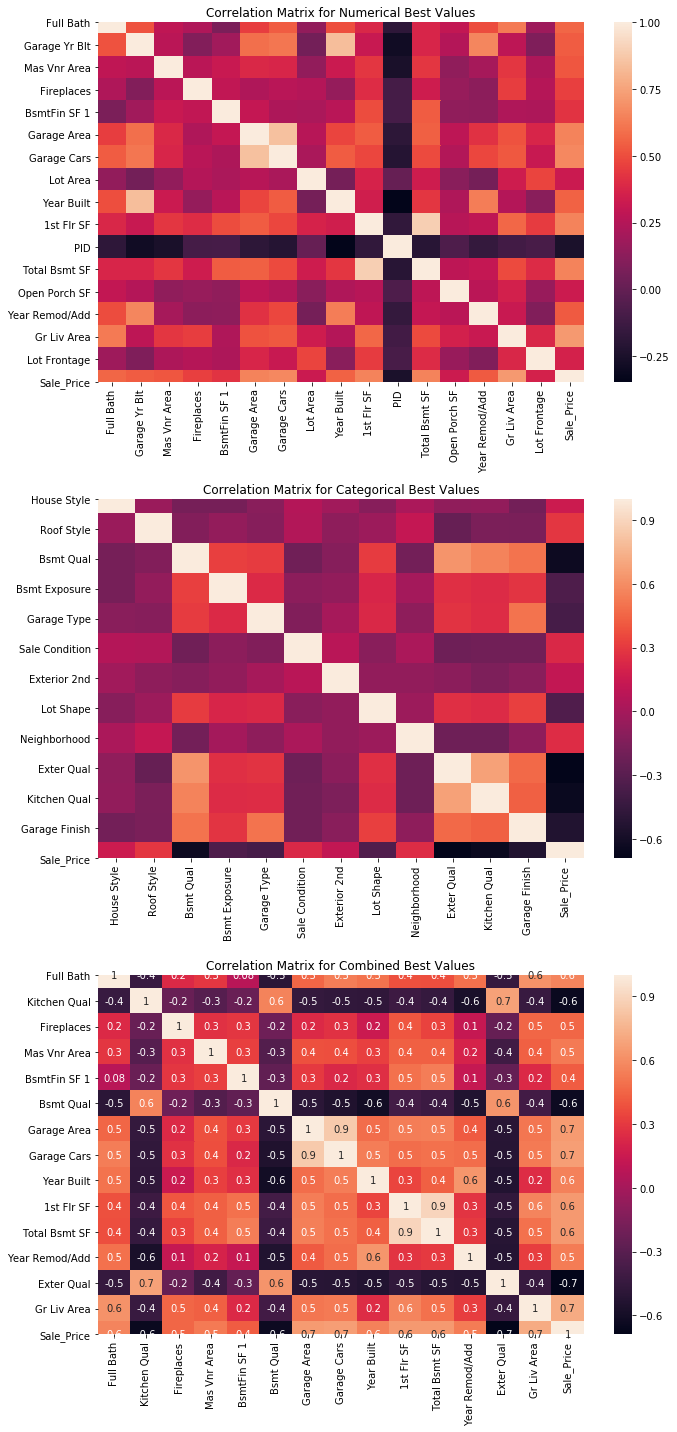

In [12]:
#correation matrix 
corr_data_num = best_numerical_features.copy()
corr_data_num['Sale_Price'] = ames_data['SalePrice']
corr_data_num_matrix = corr_data_num.corr()

corr_data_categorical = best_categorical_features.copy()
corr_data_categorical['Sale_Price'] =  ames_data['SalePrice']
corr_data_categorical_matrix = corr_data_categorical.corr()

corr_data_combined = best_combined_features.copy()
corr_data_combined['Sale_Price'] =  ames_data['SalePrice']
corr_data_combined_matrix = corr_data_combined.corr()



plt.figure(figsize=(10,20))


plt.subplot(3,1,1)
sn.heatmap(corr_data_num_matrix)
plt.title("Correlation Matrix for Numerical Best Values")


plt.subplot(3,1,2)
sn.heatmap(corr_data_categorical_matrix)
plt.title("Correlation Matrix for Categorical Best Values")
plt.tight_layout()

plt.subplot(3,1,3)
sn.heatmap(corr_data_combined_matrix, annot = True, fmt = '.1g')
plt.title("Correlation Matrix for Combined Best Values")
plt.tight_layout()




In [13]:
def random_forest_predictor(input_features, input_labels = ames_data["SalePrice"]):
    '''function that takes in the best features for a given dataframe and returns the r squared value 
    as well as the root mean squared error using Random Forest Regression'''
    X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.25)
    regr = RandomForestRegressor(n_estimators=100, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r_squared_value = metrics.r2_score(y_test, y_pred)
    return (root_mean_squared_error, r_squared_value)

In [14]:
r2_list = []
error_list = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = random_forest_predictor(input_features=feature_df)
    r2_list.append(r2)
    error_list.append(error)

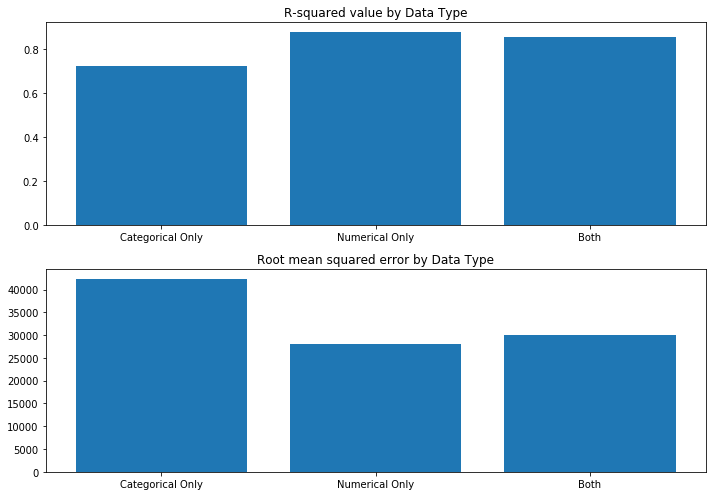

In [15]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_list)
plt.title("R-squared value by Data Type")


plt.subplot(2,1,2)
plt.bar(label_list, error_list)
plt.title("Root mean squared error by Data Type")
plt.tight_layout()


In [16]:
print(error_list)

[42391.965539999255, 27944.030249484375, 30132.572363926793]


We wanted 10 iterations to get a better picture of the r2 value for each type of data.

In [17]:
r2_dict = {"Numerical":[],"Categorical":[],"Both":[]}
for i in range(10):
    num_error, num_r2 = random_forest_predictor(input_features=best_numerical_features)
    cat_error, cat_r2 = random_forest_predictor(input_features=best_categorical_features)
    both_error, both_r2 = random_forest_predictor(input_features=best_numerical_features)
    r2_dict["Numerical"].append(num_r2)
    r2_dict["Categorical"].append(cat_r2)
    r2_dict["Both"].append(both_r2)
    

In [18]:
for (key,value) in r2_dict.items():
    print(key, ":\t", np.median(value), sep='')

Numerical:	0.8665074875340341
Categorical:	0.7311133385852561
Both:	0.882476897210694


Looks like the winner is the numerical-only data!

In [19]:
#our winners
print(best_numerical_features.columns)

Index(['Full Bath', 'Garage Yr Blt', 'Mas Vnr Area', 'Fireplaces',
       'BsmtFin SF 1', 'Garage Area', 'Garage Cars', 'Lot Area', 'Year Built',
       '1st Flr SF', 'PID', 'Total Bsmt SF', 'Open Porch SF', 'Year Remod/Add',
       'Gr Liv Area', 'Lot Frontage'],
      dtype='object')


So for the features for your chosen model, you can use either the best_numerical_features, best_categorical_features, or best_combined_features variables. The labels will be ames_data["SalePrice"].

In [20]:
from sklearn import linear_model

def Linear_Regression(input_features, input_labels = ames_data['SalePrice']):
    #X is the chosen catergories that are going to be used for prediction
    X = input_features
    #y is the sales price
    y = input_labels

    #Splitting the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #Using linear regression model to fit the data
    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    #returns the R^2 of the predicted based on X_test and the actual y_test
    return root_mean_squared_error, reg.score(X_test, y_test)

In [21]:
r2_linear = []
error_linear = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = Linear_Regression(input_features=feature_df)
    r2_linear.append(r2)
    error_linear.append(error)

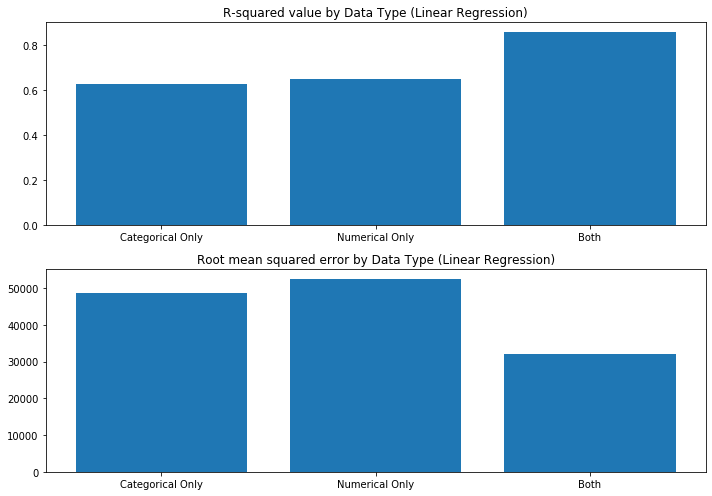

In [22]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_linear)
plt.title("R-squared value by Data Type (Linear Regression)")


plt.subplot(2,1,2)
plt.bar(label_list, error_linear)
plt.title("Root mean squared error by Data Type (Linear Regression)")
plt.tight_layout()


# Gradient Boosting 

###### To understand more about GB:https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab
###### Based on the tutorial from this website,https://acadgild.com/blog/gradient-boosting-for-regression-problems

In [26]:

def Gradient_Boosting(input_features, input_labels = ames_data['SalePrice']):
    #X is the chosen catergories that are going to be used for prediction
    X = input_features
    #y is the sales price
    y = input_labels

    #Splitting the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #Using linear regression model to fit the data
    reg = ensemble.GradientBoostingRegressor()
    reg.fit(X_train, y_train)
    
    y_pred = reg.predict(X_test)
    root_mean_squared_error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    
    #returns the R^2 of the predicted based on X_test and the actual y_test
    return root_mean_squared_error, reg.score(X_test, y_test)

In [27]:
gradient = []
error_gradient = []
feature_list = [best_categorical_features, best_numerical_features, best_combined_features]
label_list = ["Categorical Only", "Numerical Only", "Both"]

for feature_df in feature_list:
    error, r2 = Gradient_Boosting(input_features=feature_df)
    gradient.append(r2)
    error_gradient.append(error)

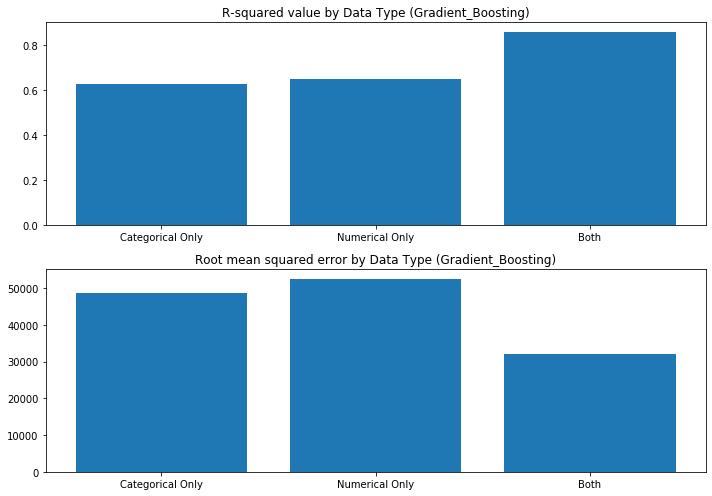

In [28]:
plt.figure(figsize=(10,7))


plt.subplot(2,1,1)
plt.bar(label_list, r2_linear)
plt.title("R-squared value by Data Type (Gradient_Boosting)")


plt.subplot(2,1,2)
plt.bar(label_list, error_linear)
plt.title("Root mean squared error by Data Type (Gradient_Boosting)")
plt.tight_layout()

we have predicted the housing prices given the categorical features and numberical data using four different alogrothim that lets us visualize which one works the best. To determine which of the algorithm works the best we have used R-squared value and Root mean squared. it seems the best one out of the four is gradient boosting. The GB is basically takes small steps depenidng how the data is structured and tries to predict the best fit line. It's the same concept from what we have learned from our calculus class. for example, you are in top of the moutian, you want to take the step(iterations) based on how fast or fit path that you can take to reach the destiation that you desire. 

# References
https://medium.com/byteridge/encoding-categorical-values-in-python-scikit-learn-51b04b4bb5fa

https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/